# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

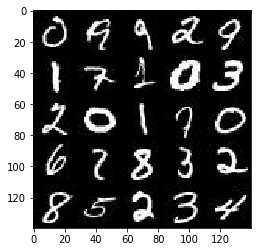

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

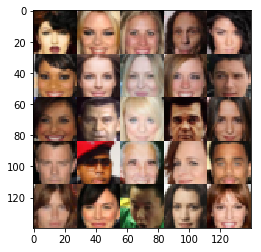

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
              
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [ ]:
import numpy as np
print(np.random.uniform(0.9,0.99))
print(np.random.uniform(0.01,0.2))

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    
    # Initialize variables
    input_real, input_z, lr_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #lr_rate = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # Convert -0.5 to 0.5 to -1 to 1 for Tanh 
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr_rate : learning_rate})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr_rate : learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))   
                    
                if steps % 350 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  
        
        # Final Output
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.5470


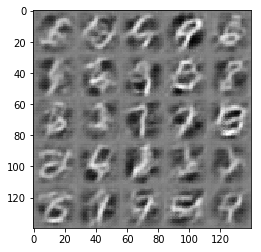

Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 0.9823
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 1.0616
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.1428


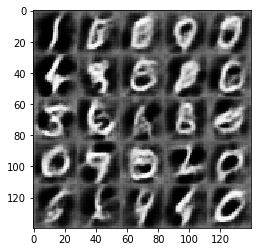

Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 1.2341
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 1.8201
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.4482


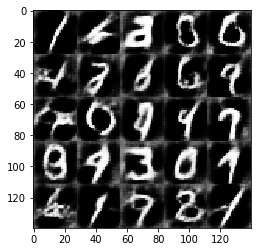

Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.9664
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 1.3522


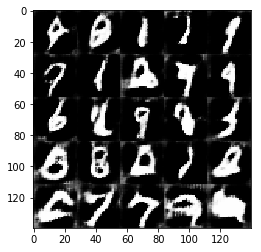

Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.7081
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.2054


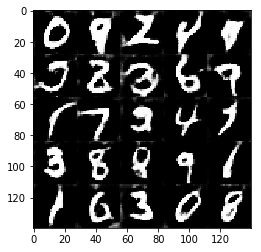

Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.5687


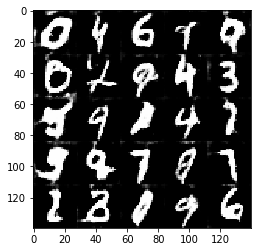

In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.4882
Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 0.7413


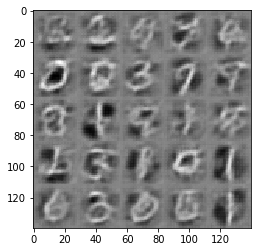

Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 0.9868


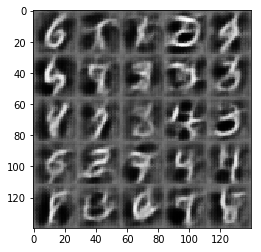

Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 1.5062
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 0.9428


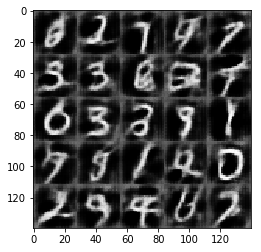

Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 3.1151
Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 1.2454
Epoch 2/2... Discriminator Loss: 0.3764... Generator Loss: 1.6043


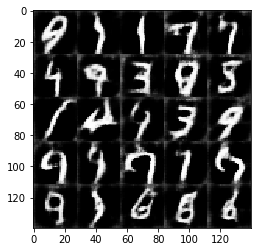

Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.6949
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 0.5354... Generator Loss: 1.1065


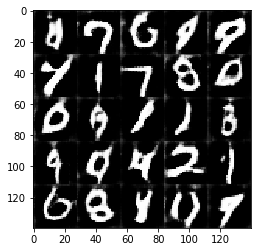

Epoch 2/2... Discriminator Loss: 0.4198... Generator Loss: 1.7317


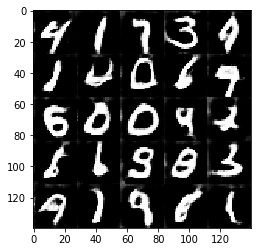

In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.2837
Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 0.8630


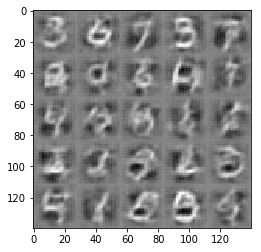

Epoch 1/2... Discriminator Loss: 1.6563... Generator Loss: 0.2836
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5445
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.5342


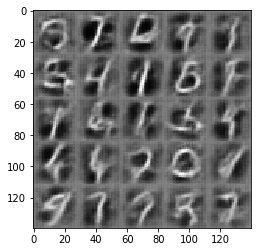

Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 0.6608... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.6218


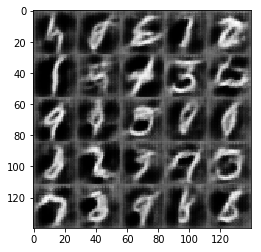

Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.3683
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.7597
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 1.5084
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 1.3458


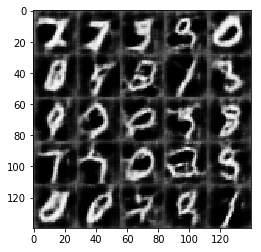

Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 0.4352... Generator Loss: 1.5090


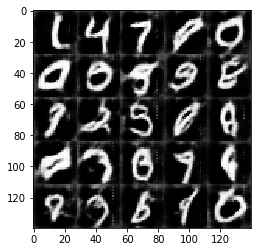

Epoch 2/2... Discriminator Loss: 0.5025... Generator Loss: 1.2460


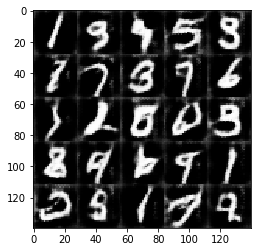

In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.2577
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 0.7764


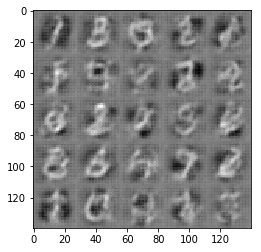

Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 1.2945
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.2016


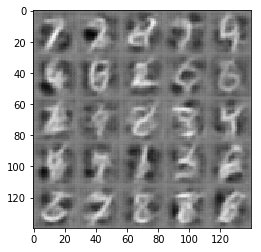

Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 0.8528
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.0259


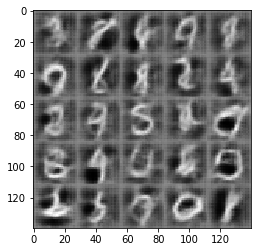

Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 0.7284
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.3724
Epoch 2/2... Discriminator Loss: 0.6004... Generator Loss: 1.9270


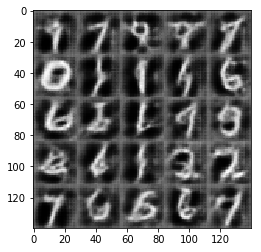

Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.0108
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 0.7682


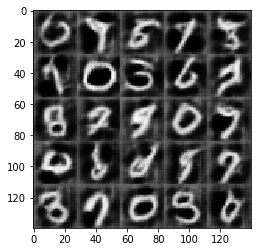

Epoch 2/2... Discriminator Loss: 0.4657... Generator Loss: 1.5580


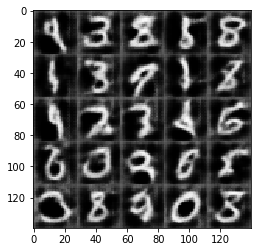

In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 1.1477
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 1.0410


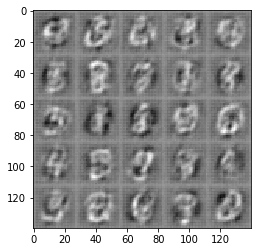

Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 1.0511
Epoch 1/2... Discriminator Loss: 0.7133... Generator Loss: 1.6408
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.0044


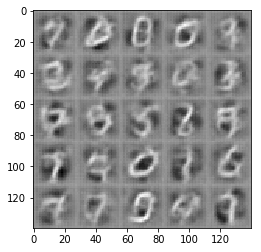

Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.4034
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 0.9962


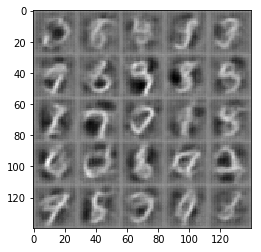

Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.4831
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 2.0141


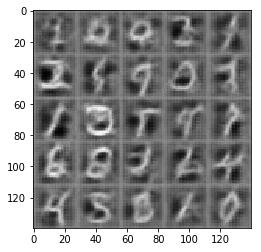

Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 0.6161... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 0.9782


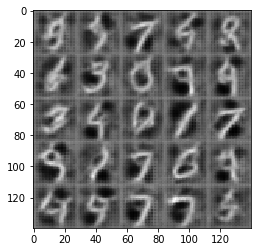

Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 1.2512


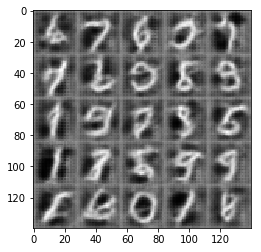

In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Experimental Results

As you can see from the above parameter combinations, it looks like with batch_size = 64, z_dim = 100 and beta1 = 0.5 the best learning_rate = 0.0004.  I'll apply this combination to the Celebrity Photos GANs.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 2.6095
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 1.8144


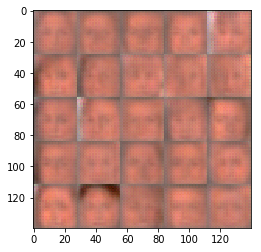

Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 1.7548
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.0456


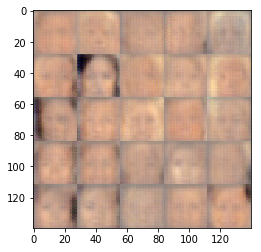

Epoch 1/1... Discriminator Loss: 1.7698... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.3648


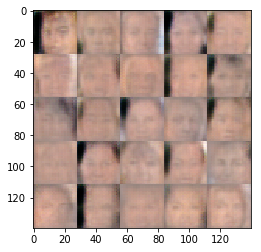

Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 2.1611
Epoch 1/1... Discriminator Loss: 0.2798... Generator Loss: 3.1090
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.5905


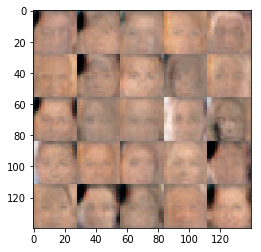

Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.4544


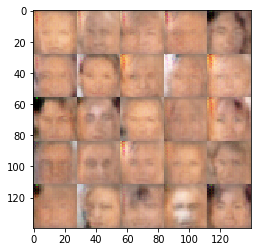

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 1.7265
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.8847


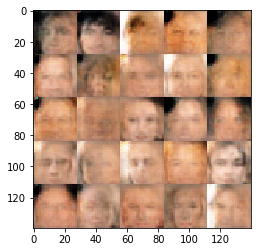

Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 1.9212


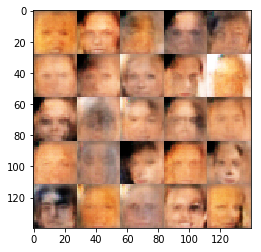

Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 2.6022
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.9468


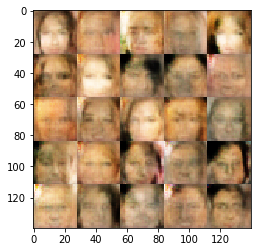

Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.6940
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.6200


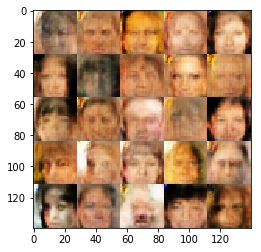

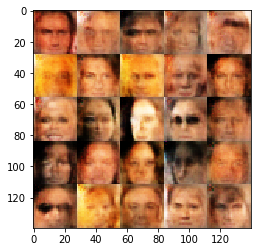

In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.